# Imports

In [2]:
import os
import cv2

from osgeo import gdal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image

2023-05-23 22:19:15.635100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:19:15.818617: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:19:15.828295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 22:19:17.245161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Connect to data on local drive & assign working folder

In [3]:
# # Function to recursively search for the "data" folder
# def find_data_folder(directory):
#     for root, dirs, files in os.walk(directory):
#         if 'data' in dirs:
#             return os.path.join(root, 'data')
#     return None

# # Specify the target directory name
# target_directory = 'AerialImageDataset'
# #target_directory ='aerialimagelabeling/NEW2-AerialImageDataset/AerialImageDataset'

# # Get the user's home directory
# home_dir = os.path.expanduser('~/code')
# print(home_dir)
# #home_dir = '/home/jfang5/code'

# # Search for the "data" folder recursively
# data_folder = find_data_folder(home_dir)

# if data_folder is None:
#     print("Could not find the 'data' folder.")
# else:
#     # Construct the absolute path by joining the data folder path with the target directory
#     absolute_path = os.path.join(data_folder, target_directory)
#     print(absolute_path)
    
    
# # Get the absolute path of the current script or notebook
current_path = os.getcwd()
print(current_path)
# Get the directory of the current script or notebook
current_directory = os.path.dirname(current_path)
# Define the path to the "AerialImageDataset" folder
absolute_path = os.path.join(current_directory, "data/AerialImageDataset")
# Change the current working directory to the "AerialImageDataset" folder
absolute_path

/home/jfang5/code/JennyF-slb/solar_ai_solutions/solar_ai/notebooks


'/home/jfang5/code/JennyF-slb/solar_ai_solutions/solar_ai/data/AerialImageDataset'

In [4]:
# Change the current working directory
os.chdir(absolute_path)

In [5]:
!pwd

/home/jfang5/code/JennyF-slb/solar_ai_solutions/solar_ai/data/AerialImageDataset


## train / images : geo-tiff Images

In [8]:
# Construct the absolute path to the "train/images" directory
train_images_dir = absolute_path + '/train/images/'

# Retrieve a list of files in the "train/images" directory
files = os.listdir(train_images_dir)

# Filter files based on criteria (e.g., file extension)
image_files = [file for file in sorted(files) if file.endswith('.tif')]

# Select a specific image from the list
selected_image = image_files[179]  # Change the index as per your requirement
selected_image

'vienna9.tif'

In [9]:
# Load the selected image
image_path = train_images_dir + selected_image
image = Image.open(image_path)

# Get the shape of the image
image_shape = image.size

# Print the shape
print("Image shape:", image_shape)

Image shape: (5000, 5000)


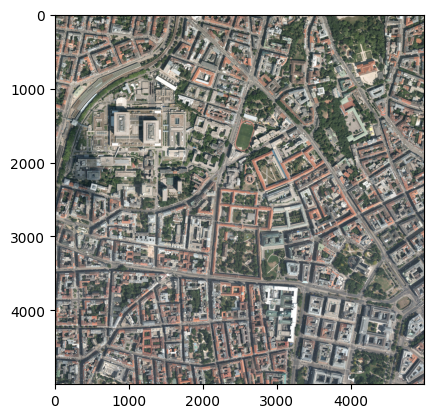

In [10]:
plt.imshow(image)

# Patching

(5000, 5000, 3) (5000, 5000)
361


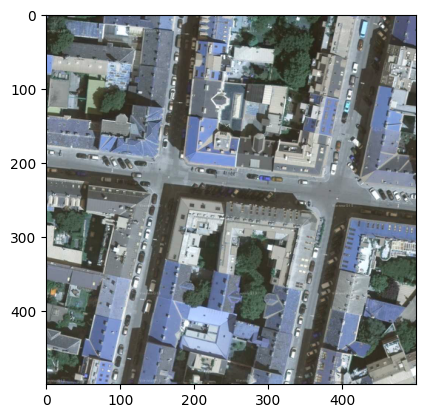

In [29]:
import numpy as np
import cv2

def create_patches(image, patch_size, overlap): #image is image array with dimention, e.g, (5000,5000,3). patch_size is 2d. overlap is a number
    height, width = image.shape[:2]    
    patch_height, patch_width = patch_size
    
    stride_height = patch_height - overlap
    stride_width = patch_width - overlap
    
    patches = []
    
    for y in range(0, height-patch_height+1, stride_height):
        for x in range(0, width-patch_width+1, stride_width):
            patch = image[y:y+patch_height, x:x+patch_width]
            patches.append(patch)
    
    return patches   #return all patches

# Example usage
#image_path = '/home/jfang5/code/JennyF-slb/solar_ai_solutions/solar_ai/data/AerialImageDataset/train/images/vienna9.tif' 
#print(image_path)
image = cv2.imread(image_path)   #read image
print(image.shape, image.shape[:2])

patch_size = (500, 500)  # Specify the desired patch size
overlap = 250  # Specify the desired overlap size, 50% for this case

patches = create_patches(image, patch_size, overlap)

print(len(patches))
plt.imshow(patches[0])

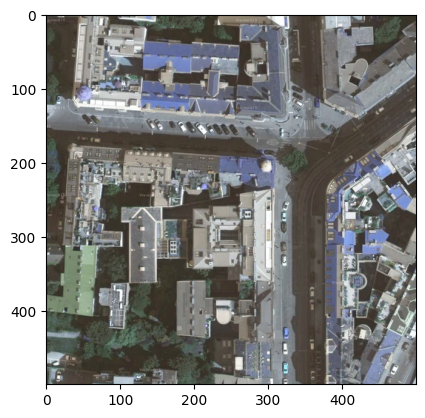

In [27]:
plt.imshow(patches[342])

In [ ]:
# Displaying the first patch
#cv2.imshow("Patch", patches[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [24]:
# Folder containing GeoTIFF files, image data
image_data = 'AerialImageDataset/train/images'
batch_size = 64

# Function to load and preprocess GeoTIFF files
def load_geotiff_data(image_folder):
    file_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder)) if filename.endswith('.tif')]
    data = []
    for file_path in file_paths:
        
        try:
            import gdal    #For Pradeesh, Abhinav, and Jenny
            # Use gdal to open TIF images
            dataset = gdal.Open(file_path,0)
            # Process the dataset using gdal

        except ImportError:   
            import rasterio    # For Ming since Ming does not have gdal
            # Use rasterio to open TIF images
            dataset = rasterio.open(file_path,0)
            # Process the dataset using rasterio

        #dataset = gdal.Open(file_path,0)
        if dataset is None:
            continue
        image = dataset.ReadAsArray() # Convert to array
        image = np.transpose(image, (1,2,0))  # Transpose the position of channels in the image
        
        # Perform any necessary preprocessing steps here (e.g., resizing, normalization)
        image = cv2.resize(image, (256, 256)) # Re-shape / re-size the image: reducing image pixel from (5000, 5000) to (256, 256)
        image = image / 255 # Normalize pixel color values between 0 and 1 from 0 and 255

        # Add the preprocessed image to the data list
        data.append(image)
        dataset = None  # Close the dataset

    return np.array(data)

## train / images : tg Images